# Evaluate XAI Sensitivity during Model Training
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/main?labpath=tutorials%2FTutorial_XAI_Sensitivity_Model_Training.ipynb)


This tutorial demonstrates how one can use the library to evaluate how explanations changes in terms of sensitivity (defined here as sparseness) while a model is training. We use a LeNet model and Fashion-MNIST dataset to showcase the library's functionality.

- Make sure to have GPUs enabled to speed up computation.

In [1]:
from IPython.display import clear_output
!pip install torch torchvision captum quantus
clear_output()

In [2]:
import pathlib
import numpy as np
import pandas as pd
import quantus
import torch
import torchvision
from captum.attr import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Enable GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
clear_output()

## 1) Preliminaries

### 1.1 Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [3]:
# Load datasets and make loaders.
test_samples = 24
transformer = torchvision.transforms.Compose([torchvision.transforms.RandomAffine(degrees=(0, 10), scale=(0.8, 1.1), interpolation=torchvision.transforms.InterpolationMode.NEAREST), 
                                              torchvision.transforms.RandomHorizontalFlip(p=0.25), 
                                              torchvision.transforms.ToTensor()])
train_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=True, transform=transformer, download=True)
test_set = torchvision.datasets.FashionMNIST(root='./sample_data', train=False, transform=transformer, download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, pin_memory=True) # num_workers=4,
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, pin_memory=True)

# Specify class labels.
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

# Load a batch of inputs and outputs to use for evaluation.
x_batch, y_batch = iter(test_loader).next()
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

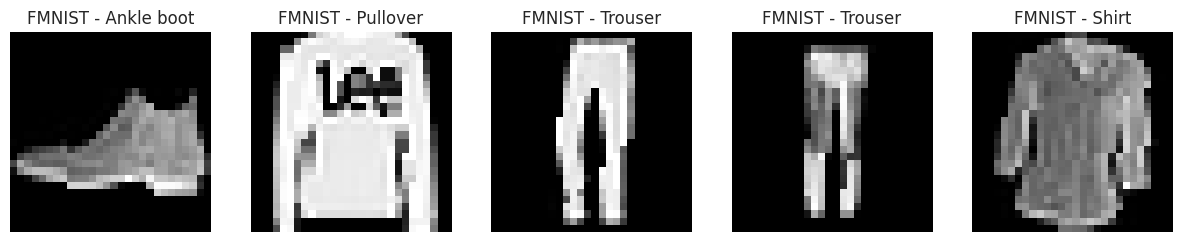

In [4]:
# Plot some inputs!
nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow(x_batch[i].cpu().numpy().reshape(28, 28), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"FMNIST - {classes[y_batch[i].item()]}")
    axes[i].axis("off")
plt.show()

## 2) Quantative evaluation using Quantus

Let's evaluate sensitivity during the model training.

In [5]:
class LeNet(torch.nn.Module):
     
    def __init__(self):   
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(16*5*5, 120)
        self.fc2 = torch.nn.Linear(120, 84)   
        self.fc3 = torch.nn.Linear(84, 10)    
        
    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))  
        x = self.max_pool_1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.max_pool_2(x)
        x = x.view(-1, 16*5*5)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load model architecture.
model = LeNet()
print(f"\n Model architecture: {model.eval()}\n")


 Model architecture: LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)



### 2.1 Evaluate explanation sensitivity

During model training/ fine-tuning calculate sensitivity scores of Integrated Gradients explanations, as a measure of sensitivity.

In [6]:
def evaluate_model(model, data, device):
    """Evaluate torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for b, (images, labels) in enumerate(data):  
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])

    return torch.nn.functional.softmax(logits, dim=1), targets

In [7]:
# Initialise the metric.
metric = quantus.LocalLipschitzEstimate(nr_samples=10,
                                        norm_numerator=quantus.similarity_func.distance_euclidean,
                                        norm_denominator=quantus.similarity_func.distance_euclidean,
                                        perturb_func=quantus.perturb_func.gaussian_noise,
                                        perturb_mean=0.0,
                                        perturb_std=0.1,
                                        similarity_func=quantus.similarity_func.lipschitz_constant,
                                        return_aggregate=False,
                                        disable_warnings=True,
                                        normalise=True,
                                        abs=False)

# Set necessary configs/ parameters.
model.to(device)  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 20
sensitivities = {}

# Run the analysis!
for epoch in range(epochs):
    model.train()
    
    for b, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        logits = model(images)

        loss = criterion(logits, labels)
        model.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate model!
    predictions, labels = evaluate_model(model, test_loader, device)
    test_acc = np.mean(np.argmax(predictions.cpu().detach().numpy(), axis=1) == labels.detach().cpu().numpy())
    
    # Explain model (on a few test samples) and measure sensitivies.
    sensitivities[epoch] = metric(model=model, 
                                  x_batch=x_batch.cpu().numpy(),
                                  y_batch=y_batch.cpu().numpy(),
                                  a_batch=None,
                                  device=device,
                                  explain_func=quantus.explain,
                                  explain_func_kwargs={"method": "IntegratedGradients"})
            
    print(f"Epoch {epoch+1}/{epochs} - loss {loss.item():.2f} - test accuracy: {(100 * test_acc):.2f}% - max sensitivity {np.mean(sensitivities[epoch]):.2f}")

/home/fe/lweber/work-code/Quantus/quantus/helpers/warn.py:262: UserWarning: The settings for perturbing input e.g., 'perturb_func' didn't cause change in input. Reconsider the parameter settings.
  warnings.warn(


Epoch 1/20 - loss 0.62 - test accuracy: 74.15% - max sensitivity 1.07
Epoch 2/20 - loss 0.49 - test accuracy: 78.52% - max sensitivity 1.12
Epoch 3/20 - loss 0.58 - test accuracy: 81.38% - max sensitivity 1.18
Epoch 4/20 - loss 0.48 - test accuracy: 80.61% - max sensitivity 1.20
Epoch 5/20 - loss 0.52 - test accuracy: 83.28% - max sensitivity 1.19
Epoch 6/20 - loss 0.44 - test accuracy: 83.76% - max sensitivity 1.21
Epoch 7/20 - loss 0.48 - test accuracy: 85.26% - max sensitivity 1.23
Epoch 8/20 - loss 0.35 - test accuracy: 84.58% - max sensitivity 1.23
Epoch 9/20 - loss 0.34 - test accuracy: 85.71% - max sensitivity 1.27
Epoch 10/20 - loss 0.42 - test accuracy: 85.86% - max sensitivity 1.28
Epoch 11/20 - loss 0.40 - test accuracy: 86.67% - max sensitivity 1.29
Epoch 12/20 - loss 0.34 - test accuracy: 86.22% - max sensitivity 1.29
Epoch 13/20 - loss 0.36 - test accuracy: 86.00% - max sensitivity 1.29
Epoch 14/20 - loss 0.34 - test accuracy: 86.82% - max sensitivity 1.31
Epoch 15/20 - l

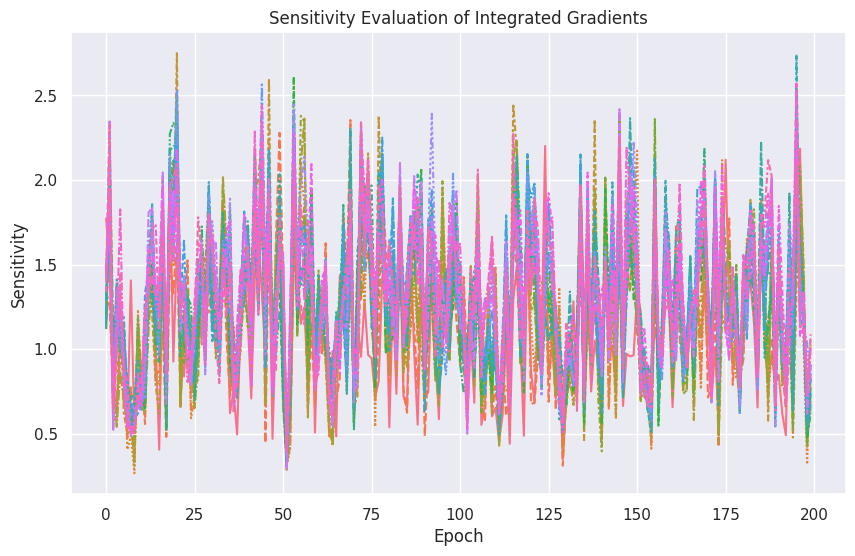

In [8]:
# Summarise in a dataframe.      
df = pd.DataFrame.from_dict(sensitivities)

# Plot!
plt.figure(figsize=(10,6))
sns.lineplot(data=df, estimator='mean', legend=None)
plt.title("Sensitivity Evaluation of Integrated Gradients")
plt.xlabel("Epoch")
plt.ylabel("Sensitivity");